In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline

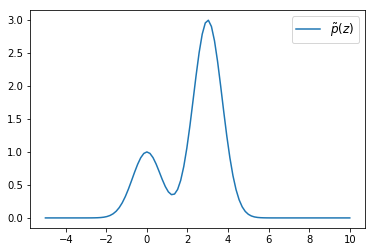

In [2]:
def func(x):
    return np.exp(-x ** 2) + 3 * np.exp(-(x - 3) ** 2)
x = np.linspace(-5, 10, 100)

plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.legend(fontsize=12)
plt.show()

## The Metropolis algorithm

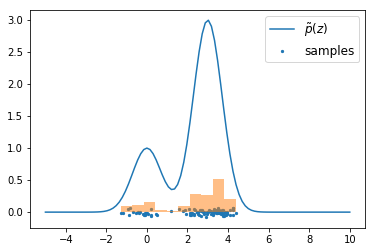

In [3]:
downsample = 10

z = 0
samples = []
for i in range(1000):
    z_new = z + stats.norm(0, 1).rvs() # proposal distribution norm(0, 1) is symmetric at the origin
    accept_proba = func(z_new) / func(z)
    if np.random.uniform(0, 1) < accept_proba:
        z = z_new
    if i % downsample == 0:
        samples.append(z)
samples = np.asarray(samples)

plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, density=True, alpha=0.5)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=12)
plt.show()

## The Metropolis-Hastings algorithm

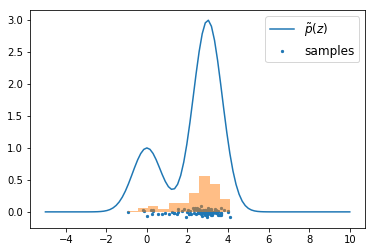

In [4]:
downsample = 10

z = 0
samples = []
for i in range(1000):
    z_new = z + stats.norm(1, 1).rvs()
    accept_proba = func(z_new) * stats.norm(1, 1).pdf(z - z_new) / (func(z) * stats.norm(1, 1).pdf(z_new - z))
    # proposal distribution norm(1, 1) is NOT symmetric at the origin
    if np.random.uniform(0, 1) < accept_proba:
        z = z_new
    if i % downsample == 0:
        samples.append(z)
samples = np.asarray(samples)

plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, density=True, alpha=0.5)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=12)
plt.show()

## Metropolis-Hastings random walk algorithm for estimating the bias of a coin 

The fundamental objective of Bayesian data analysis is to determine the posterior distribution
$$p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{p(X)}$$
where the denominator is
$$p(X) = \int p(X \ | \ \theta^*) p(\theta^*) d\theta^*  $$ 
Here,
- $p(\theta \ | \ X)$  is the likelihood
- $p(θ)$ is the prior and
- $p(X)$ is a normalizing constant also known as the evidence or marginal likelihood

The computational issue is the difficulty of evaluating the integral in the denominator.

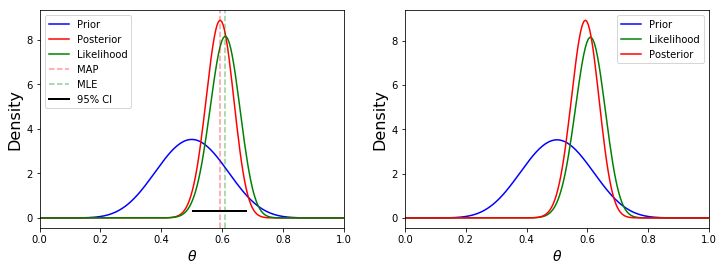

In [5]:
n = 100 # number of tosses
h = 61  # number of heads
p = h/n # MLE

a, b = 10, 10
thetas = np.linspace(0, 1, 200)
prior = stats.beta(a, b)

# Given prior of theta, we have analytic solution for post of theta
post = stats.beta(h+a, n-h+b)
ci = post.interval(0.95)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(p, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left')

# If analytic solution is not available, we can have numerical integration
# However, this is computationally very expensive when we need to estimate multiple parameters
post = prior.pdf(thetas) * stats.binom(n, thetas).pmf(h)
post /= (post.sum() / len(thetas)) # Normalzied so volume is 1

plt.subplot(1, 2, 2)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend()
plt.show()

Efficiency =  0.060875


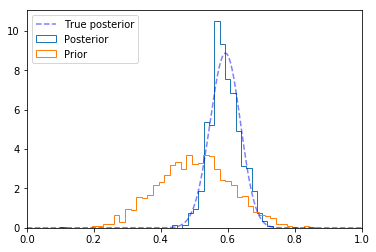

In [6]:
def approx(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

lik = stats.binom
prior = stats.beta(a, b)

naccept = 0
theta = 0.1
niters = 8000

downsample = 5
samples = []
for i in range(niters):
    theta_p = theta + stats.norm(0, 1).rvs()
    accept_proba = min(1, approx(lik, prior, n, h, theta_p)/approx(lik, prior, n, h, theta))
    if np.random.uniform() < accept_proba:
        naccept += 1
        theta = theta_p
    if i % downsample == 0:
        samples.append(theta)
print("Efficiency = ", naccept/niters)

post = stats.beta(h+a, n-h+b)
plt.plot(thetas, post.pdf(thetas), c='blue', linestyle='--', alpha=0.5, label='True posterior')
plt.hist(samples, 40, histtype='step', density=True, linewidth=1, label='Posterior');
plt.hist(prior.rvs(len(samples)), 40, histtype='step', density=True, linewidth=1, label='Prior');
plt.xlim([0,1]);
plt.legend(loc='upper left')
plt.show()

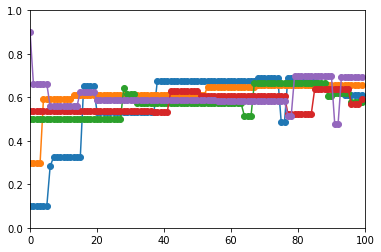

In [7]:
niters = 100
for theta in np.arange(0.1, 1, 0.2):
    samples = []
    for i in range(niters):
        theta_p = theta + stats.norm(0, 1).rvs()
        accept_proba = min(1, approx(lik, prior, n, h, theta_p)/approx(lik, prior, n, h, theta))
        if np.random.uniform() < accept_proba:
            theta = theta_p
        samples.append(theta)
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

### Why does Metropolis-Hastings work?
- There is a unique stationary state
- The stationary state is the posterior probability distribution